<a href="https://colab.research.google.com/github/RRG314/topological-adam/blob/paper/ARC_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Downloading ARC dataset...
✅ Extracted ARC data.
✅ Found 400 training tasks.
✅ Using device: cpu

🔹 Task 1/20: 007bbfb7.json
Adam                 | Ep  200 | Loss=6.711e-03
Adam                 | Ep  400 | Loss=1.035e-03
Adam                 | Ep  600 | Loss=4.743e-04
Adam                 | Ep  800 | Loss=2.425e-04
Adam                 | Ep 1000 | Loss=1.185e-04
Adam+RDT             | Ep  200 | Loss=3.121e-03
Adam+RDT             | Ep  400 | Loss=8.749e-04
Adam+RDT             | Ep  600 | Loss=3.699e-04
Adam+RDT             | Ep  800 | Loss=1.796e-04
Adam+RDT             | Ep 1000 | Loss=9.696e-05
TopologicalAdam      | Ep  200 | Loss=9.885e-04
TopologicalAdam      | Ep  400 | Loss=2.318e-04
TopologicalAdam      | Ep  600 | Loss=6.046e-05
TopologicalAdam      | Ep  800 | Loss=1.890e-05
TopologicalAdam      | Ep 1000 | Loss=7.369e-06
TopologicalAdam+RDT  | Ep  200 | Loss=8.291e-04
TopologicalAdam+RDT  | Ep  400 | Loss=2.781e-04
TopologicalAdam+RDT  | Ep  600 | Loss=1.399e-04
Topologic

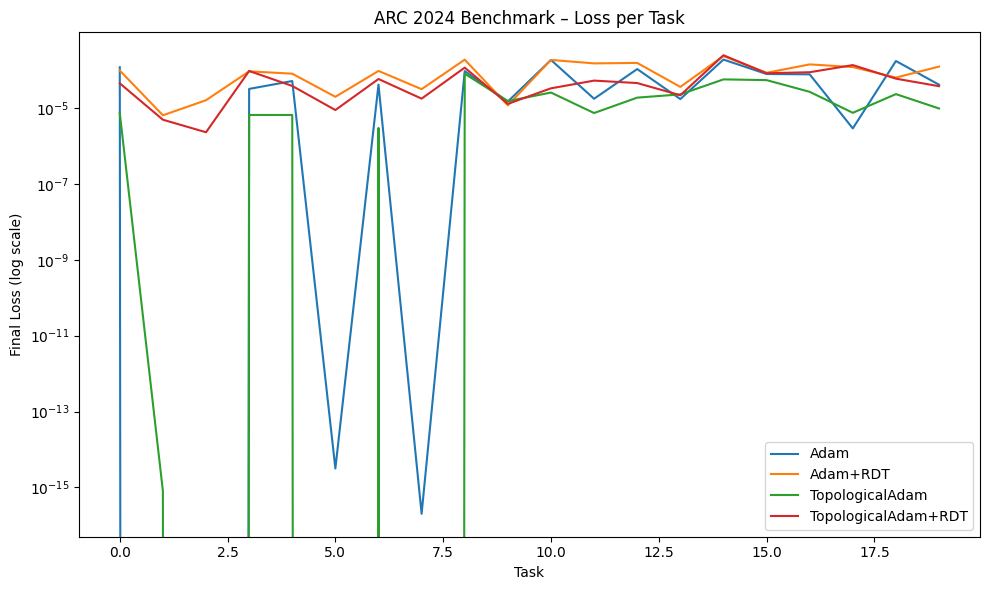

In [1]:
# ============================================================
# ARC-AGI 2024 BENCHMARK — RDT + Topological Adam (Pro)
# FINAL FIXED VERSION — safe RDT projection
# ============================================================

import os, json, time, math, zipfile, requests, csv
import torch, torch.nn as nn, torch.autograd as autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ============================================================
# === Embedded RDT Kernel ====================================
# ============================================================

def rdt_kernel(L, alpha=0.5, D=0.1, dx=1.0):
    """Simple recursive diffusion transform kernel."""
    L = torch.nan_to_num(L, nan=0.0, posinf=0.0, neginf=0.0)
    up, down = torch.roll(L, 1, 0), torch.roll(L, -1, 0)
    left, right = torch.roll(L, 1, 1), torch.roll(L, -1, 1)
    diff = (up + down + left + right - 4 * L)
    step = L + alpha * D * diff / (dx * dx)
    return torch.tanh(step)

def safe_rdt_apply(v):
    """Applies RDT kernel safely on a 1D tensor and returns SAME-LENGTH vector."""
    n = v.numel()
    s = int(math.sqrt(n))
    if s * s < n:
        s += 1
    pad_len = s * s - n
    padded = F.pad(v, (0, pad_len), value=0.0)
    grid = padded.view(s, s)
    rdt_grid = rdt_kernel(grid)
    flat = rdt_grid.flatten()[:n]
    # normalize to match original range
    flat = (flat - flat.mean()) / (flat.std() + 1e-8)
    return flat.view_as(v)

# ============================================================
# === Embedded Topological Adam ==============================
# ============================================================

class TopologicalAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-8,
                 eta=0.1, mu0=1.0, w_topo=0.05, E_target=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        eta=eta, mu0=mu0, w_topo=w_topo, E_target=E_target)
        super().__init__(params, defaults)
        self.alpha = {}; self.beta = {}

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure: loss = closure()
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)
                    self.alpha[p] = torch.zeros_like(p)
                    self.beta[p] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])
                step_size = group["lr"]

                J = (self.alpha[p] - self.beta[p]) * grad
                eta, mu0 = group["eta"], group["mu0"]
                self.alpha[p] = (1 - eta) * self.alpha[p] + (eta / mu0) * J
                self.beta[p] = (1 - eta) * self.beta[p] - (eta / mu0) * J

                E = 0.5 * (self.alpha[p].pow(2).mean() + self.beta[p].pow(2).mean())
                if E > group["E_target"]:
                    scale = math.sqrt(group["E_target"] / (E + 1e-12))
                    self.alpha[p].mul_(scale)
                    self.beta[p].mul_(scale)

                p.addcdiv_(exp_avg, denom, value=-step_size)
                p.add_(torch.tanh(self.alpha[p] - self.beta[p]) * -group["w_topo"])
                state["step"] += 1
        return loss

# ============================================================
# === ARC Data Loader ========================================
# ============================================================

def get_arc_data():
    url = "https://github.com/fchollet/ARC-AGI/archive/refs/heads/master.zip"
    fname = "arc_data.zip"
    if not os.path.exists("arc_data"):
        print("📥 Downloading ARC dataset...")
        r = requests.get(url)
        open(fname, "wb").write(r.content)
        with zipfile.ZipFile(fname, "r") as z:
            z.extractall("arc_data")
        print("✅ Extracted ARC data.")
    base = "arc_data/ARC-AGI-master/data/training"
    files = sorted([os.path.join(base, f) for f in os.listdir(base) if f.endswith(".json")])
    print(f"✅ Found {len(files)} training tasks.")
    return files[:20]

# ============================================================
# === Simple MLP =============================================
# ============================================================

class TinyMLP(nn.Module):
    def __init__(self, input_dim=2, hidden=64, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# ============================================================
# === Benchmark ==============================================
# ============================================================

def run_arc_benchmark():
    tasks = get_arc_data()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"✅ Using device: {device}")

    results = []

    for idx, file in enumerate(tasks):
        with open(file, "r") as f:
            task = json.load(f)
        print(f"\n🔹 Task {idx+1}/{len(tasks)}: {os.path.basename(file)}")

        in_grids = [torch.tensor(t["input"], dtype=torch.float32) for t in task["train"]]
        out_grids = [torch.tensor(t["output"], dtype=torch.float32) for t in task["train"]]

        # --- Safe padding for variable sizes ---
        max_h = max(max(g.shape[0] for g in in_grids), max(g.shape[0] for g in out_grids))
        max_w = max(max(g.shape[1] for g in in_grids), max(g.shape[1] for g in out_grids))

        def pad_to_size(g, h, w):
            pad_h = h - g.shape[0]
            pad_w = w - g.shape[1]
            return F.pad(g, (0, pad_w, 0, pad_h), value=0.0)

        in_grids = [pad_to_size(g, max_h, max_w) for g in in_grids]
        out_grids = [pad_to_size(g, max_h, max_w) for g in out_grids]

        x = torch.cat([g.flatten().unsqueeze(1) for g in in_grids], dim=0)
        y = torch.cat([g.flatten().unsqueeze(1) for g in out_grids], dim=0)
        data = torch.cat([x, y], dim=1)
        data = (data - data.mean()) / (data.std() + 1e-8)

        def train_model(opt_name, opt_class, use_rdt=False, epochs=1000):
            model = TinyMLP(2 if not use_rdt else 3).to(device)
            opt = opt_class(model.parameters(), lr=1e-3)
            loss_fn = nn.MSELoss()
            start = time.time()

            for ep in range(1, epochs + 1):
                opt.zero_grad()
                X = data[:, :1].to(device)
                Y = data[:, 1:].to(device)
                inp = torch.cat([X, Y], dim=1)
                if use_rdt:
                    rdt_feat = safe_rdt_apply(inp.mean(dim=1))  # compress across dims safely
                    inp = torch.cat([inp, rdt_feat.unsqueeze(1)], dim=1)
                pred = model(inp)
                loss = loss_fn(pred, Y)
                loss.backward()
                opt.step()
                if ep % 200 == 0:
                    print(f"{opt_name:<20} | Ep {ep:4d} | Loss={loss.item():.3e}")
            return time.time() - start, loss.item()

        combos = [
            ("Adam", torch.optim.Adam, False),
            ("Adam+RDT", torch.optim.Adam, True),
            ("TopologicalAdam", TopologicalAdam, False),
            ("TopologicalAdam+RDT", TopologicalAdam, True),
        ]

        for name, opt, rdt_flag in combos:
            t, L = train_model(name, opt, rdt_flag)
            results.append(dict(Task=file, Optimizer=name, FinalLoss=L, Time=t))

    # --- Save results ---
    with open("arc_results.csv", "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)
    print("✅ Results saved: arc_results.csv")

    # --- Plot summary ---
    plt.figure(figsize=(10, 6))
    for opt in ["Adam", "Adam+RDT", "TopologicalAdam", "TopologicalAdam+RDT"]:
        vals = [r["FinalLoss"] for r in results if r["Optimizer"] == opt]
        plt.plot(vals, label=opt)
    plt.yscale("log")
    plt.legend()
    plt.title("ARC 2024 Benchmark – Loss per Task")
    plt.xlabel("Task")
    plt.ylabel("Final Loss (log scale)")
    plt.tight_layout()
    plt.savefig("arc_benchmark.png")
    print("✅ Saved: arc_benchmark.png")

    print("\n✅ All ARC-AGI benchmarks completed.")
    return results

# ============================================================
# === Run ====================================================
# ============================================================

if __name__ == "__main__":
    run_arc_benchmark()

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("arc_results.csv")
summary = df.groupby("Optimizer")["FinalLoss"].agg(["mean","median","min","max"])
print(summary)

                         mean    median       min       max
Optimizer                                                  
Adam                 0.000062  0.000041  0.000000  0.000188
Adam+RDT             0.000096  0.000093  0.000006  0.000233
TopologicalAdam      0.000019  0.000009  0.000000  0.000080
TopologicalAdam+RDT  0.000060  0.000045  0.000002  0.000245
